# Analysing Vaccination Strategies in the Detailed Model

- Using the 11 age groups from TABNET, calculated rates and everything
- We will analyse strategies for cities with different values of $\beta$ and, therefore, with different patterns of susceptibility 
- First, we will analyse different strategies with the same vaccination rate for both cities over different years
- Then, we will use different vaccination rates for different strategies and do a heatplot of reduction of cases overall

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
np.random.seed(123)

In [91]:
@np.vectorize
def beta_step(beta_0,beta_aug,t_start,t_season,t_year,t):
  # beta_0 is the basal beta
  # beta_aug is the beta at high transmission season
  # t_start is start time of the high transmission season
  # t_season is the duration of the high transmission season
  # t_year is the duration of a year (giving the function periodicity)
  # t is current time time
  # normalize time up to a year
  t_norm = t%t_year
  # and now we look for the value of the function
  if(t_norm >= t_start and t_norm <= t_start + t_season):
    value = beta_aug
  else:
    value = beta_0
  return value

In [92]:
def calculate_l_vector(alpha,l1):
    list_l = [] # creando uma lista l l1, l2, l3, .....
    elements_l = alpha.shape[0]
    for i in range(elements_l):
        # if it is the first element
        if(i == 0):
            list_l.append(l1)
        elif(i == elements_l-1): # if it is the last element (mortality term)
            list_l.append(list_l[-1]*alpha[-2]/alpha[-1])
        else: # in other case (intermediate elements)
            list_l.append(list_l[-1]*alpha[i-1]/alpha[i])
    return list_l

In [93]:
def n_groups_seasonal_model_vaccine(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    V = y[4*N:5*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    V = np.append(V,0)
    V = np.append(0,V)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2] - r_vec*(S[1:-1]/(S[1:-1] + R[1:-1]))
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2] - r_vec*(R[1:-1]/(S[1:-1] + R[1:-1]))
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    dVdt = r_vec - mu_vec*V[1:-1] - l_vec*V[1:-1] + l_vec_2*V[:-2]
    return np.array([dSdt, dIdt, dRdt,dCdt, dVdt]).flatten()

In [156]:
def n_groups_seasonal_model_vaccine_death(y, t, N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r_vec, d_vec):
    # N is number of age groups 
    S = y[0:N]
    I = y[N:2*N]
    R = y[2*N:3*N]
    C = y[3*N:4*N]
    V = y[4*N:5*N]
    D = y[5*N:6*N]
    beta = beta_step(beta_0,beta_aug,t_start,t_season,t_year,t)
    IT = sum(I) #total infected
    S = np.append(S,0)
    I = np.append(I,0)
    R = np.append(R,0)
    S = np.append(0,S)
    I = np.append(0,I)
    R = np.append(0,R)
    C = np.append(C,0)
    C = np.append(0,C)
    V = np.append(V,0)
    V = np.append(0,V)
    D = np.append(D,0)
    D = np.append(0,D)
    l_vec_2 = np.append(0,l_vec)
    l_vec_2 = l_vec_2[:-1]
    dSdt = -beta*S[1:-1]*IT - mu_vec*S[1:-1] - l_vec*S[1:-1] + l_vec_2*S[:-2] - r_vec*(S[1:-1]/(S[1:-1] + R[1:-1]))
    dIdt =  beta*S[1:-1]*IT - gamma*I[1:-1] - mu_vec*I[1:-1] - l_vec*I[1:-1] + l_vec_2*I[:-2]
    dRdt =  gamma*I[1:-1] - mu_vec*R[1:-1] - l_vec*R[1:-1] + l_vec_2*R[:-2] - r_vec*(R[1:-1]/(S[1:-1] + R[1:-1]))
    dSdt[0] = dSdt[0] + nu
    dCdt = beta*S[1:-1]*IT
    dVdt = r_vec - mu_vec*V[1:-1] - l_vec*V[1:-1] + l_vec_2*V[:-2]
    dDdt = beta*S[1:-1]*IT*d_vec
    return np.array([dSdt, dIdt, dRdt,dCdt, dVdt, dDdt]).flatten()

In [95]:
def modify_initial_condition(y):
    y_aux = y.copy()
    y_tmp = y.copy()
    y_tmp[:N] = (y_aux[:N]*pop - 1)/pop # suscteptible reduction
    y_tmp[N:2*N] = (y_aux[N:2*N]*pop + 1)/pop # infected grow
    y_tmp[3*N:4*N] = (y_aux[3*N:4*N]*pop + 1)/pop  # increase in new cases per day
    return y_tmp

In [97]:
def define_initial_condition():
    y0 = np.array([alpha1,alpha2,alpha3,alpha4,(alpha5*pop-1)/pop,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,])
    return y0

In [96]:
def define_initial_condition_2():
    y0 = np.array([alpha1,alpha2,alpha3,alpha4,(alpha5*pop-1)/pop,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       1/pop,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0,
            0,   0,      0,     0,       0,            0,    0,     0,     0,     0,      0])
    return y0

In [98]:
# number of age groups
N = 11

# number of people per age group
alpha1 = 793061 # 0 to 4 
alpha2 = 803773 # 5 to 9
alpha3 = 836496 # 10 to 14
alpha4 = 877970 # 15 to 19
alpha5 = 1960304 # 20 to 29
alpha6 = 1995084 # 30 to 39
alpha7 = 1666076 # 40 to 49
alpha8 = 1319655 # 50 to 59
alpha9 = 878162 # 60 to 59
alpha10 = 476538 # 70 to 79 
alpha11 = 245667 # 80+

# creating vector of alphas
alpha_pop = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])

# total population 
pop = alpha_pop.sum()

# dividing by total population
alpha1 = alpha1/pop
alpha2 = alpha2/pop
alpha3 = alpha3/pop
alpha4 = alpha4/pop
alpha5 = alpha5/pop
alpha6 = alpha6/pop
alpha7 = alpha7/pop
alpha8 = alpha8/pop
alpha9 = alpha9/pop
alpha10 = alpha10/pop
alpha11 = alpha11/pop

# creating a new vector of alphas (divided by overall population, as proportions)
alpha = np.array([alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, 
                  alpha7, alpha8, alpha9, alpha10, alpha11])


# demographical constants for the model
l1 = 1/(365*5) # how long does the first age group last (in days)?
nu = l1*alpha[0] # calculating the corresponding birth rate
l_vec = calculate_l_vector(alpha, l1) # calculating l aging elements + coupled death rate
mu_vec = np.array([0,0,0,0,0,0,0,0,0,0, l_vec[-1]]) # death rates array
# calculating aging rates vector
l_vec = l_vec[:-1] 
l_vec.append(0)
l_vec = np.array(l_vec)


# disease parameters
gamma = 1/(7.0)
beta_0 = 0.0*gamma

# year parameters for disease seasonality
t_year = 365
t_start = 0
t_season = 60

# a characteristic season
t_season_single = np.arange(0,365,1)

# number of seasons to simulate
seasons = 40

In [99]:
# defining the beta values
beta_1 = 2.0*gamma
beta_2 = 5.0*gamma

## Part 1: Different vaccination strategies for different values of $\beta$

- Sort of a proof of concept for two different beta values
- Calculating the number of cases as a function of time, for a fixed value of vaccination rate $r$ as well

### SP Pattern

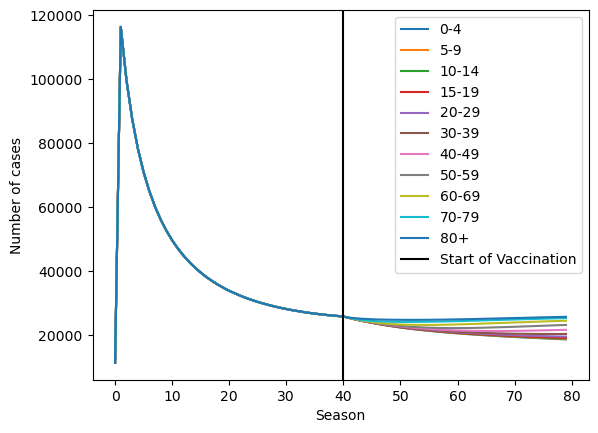

In [101]:
beta_aug = beta_1
inf_str = []

for i in range(N):
    inf_ano = []

    # before intervention
    #print('before intervention')
    r0_vec = np.zeros(N)
    y0 = define_initial_condition()
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,33:44] - ret[:-1,33:44]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()


    # after intervention
    #print('after intervention')
    r0_vec = np.zeros(11)
    r0_vec[i] = ((10000)/365)*(1/pop)
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,33:44] - ret[:-1,33:44]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()
    
    inf_str.append(inf_ano)
    
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.show()

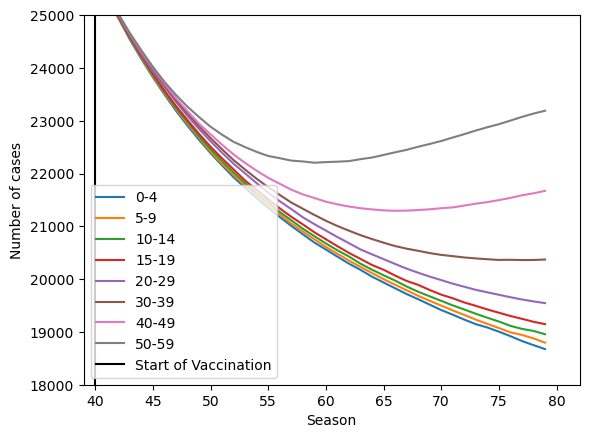

In [102]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(8):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.xlim((39,82))
plt.ylim((18000,25000))
plt.show()

### RJ Pattern

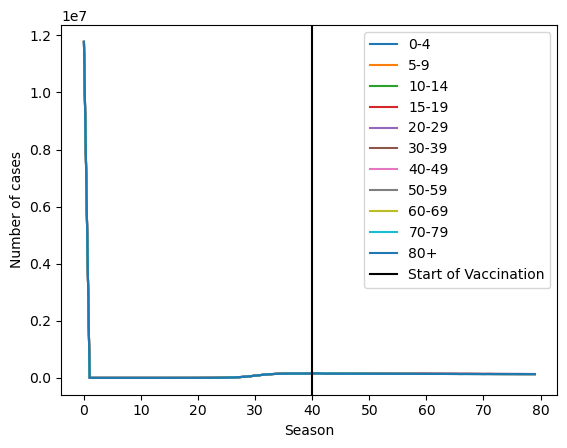

In [103]:
beta_aug = beta_2
inf_str = []

for i in range(N):
    inf_ano = []

    # before intervention
    #print('before intervention')
    r0_vec = np.zeros(N)
    y0 = define_initial_condition()
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()


    # after intervention
    #print('after intervention')
    r0_vec = np.zeros(11)
    r0_vec[i] = ((10000)/365)*(1/pop)
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,33:] - ret[:-1,33:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()
    
    inf_str.append(inf_ano)
    
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.show()

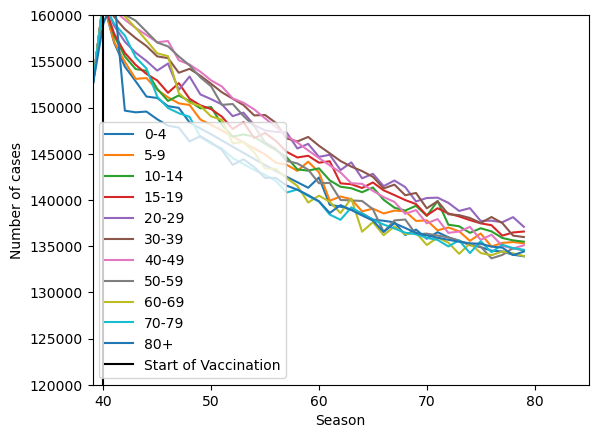

In [104]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(11):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.ylim((120000,160000))
plt.xlim((39,85))
plt.show()

## Part 2: Analysing vaccination rate - strategy as raw numbers accumulated later

### SP Pattern

In [128]:
beta_aug = beta_1
inf_str = []
vacc_rates = (np.array([0,10000,25000,50000,75000,100000])/(365))*(1/pop)

for vacc_rate in vacc_rates:
    print(vacc_rate)
    inf_rates = []
    for i in range(N):
        inf_ano = []
        # before intervention
        #print('before intervention')
        r0_vec = np.zeros(11)
        y0 = define_initial_condition()
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,33:44] - ret[:-1,33:44]).sum(axis = 1).sum()
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()


        # after intervention
        #print('after intervention')
        r0_vec = np.zeros(11)
        r0_vec[i] = vacc_rate
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,33:44] - ret[:-1,33:44]).sum(axis = 1).sum()
            inf_ano.append(inf_total)
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()

        inf_rates.append(np.sum(inf_ano))
    inf_str.append(inf_rates)

0.0
2.3114616490985835e-06
5.778654122746459e-06
1.1557308245492919e-05
1.7335962368239375e-05
2.3114616490985837e-05


In [129]:
inf_str

[[1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676,
  1016883.4780848676],
 [846231.5266076102,
  848406.8642538902,
  850989.252149286,
  854401.3303328191,
  861501.17427463,
  872380.6506765318,
  891288.2306758827,
  919891.8825137981,
  955185.5845352169,
  986470.9131362938,
  1006106.1971504523],
 [641255.2621155365,
  644956.1217524158,
  649798.5819791125,
  655933.6963430021,
  669281.6211793099,
  688823.368603519,
  725333.7745059854,
  786772.9396103898,
  867486.0969064094,
  941717.6159338324,
  990170.895686812],
 [423337.4981430444,
  426955.15381371864,
  431825.4228017243,
  437892.8265896709,
  452242.94545762317,
  474760.6049864639,
  517961.97053298727,
  600424.6038705083,
  730695.7440699368,
  869537.0760023245,
  963477.016832785],
 [299864.1445983647,
  302657.0753180664,
  305991.58823757473,

In [130]:
inf_str_bk = inf_str

In [131]:
inf_str = inf_str_bk

In [132]:
inf_str = np.array(inf_str)

In [133]:
inf_str = 100*abs(inf_str-1016883.4780848676)/(1016883.4780848676)

In [134]:
inf_str = inf_str[1:,:]

In [135]:
inf_str

array([[16.781859  , 16.56793698, 16.31398577, 15.97844308, 15.28024667,
        14.2103624 , 12.35099695,  9.53812287,  6.06735136,  2.99076203,
         1.0598344 ],
       [36.9391601 , 36.57521873, 36.09901272, 35.49568751, 34.1830568 ,
        32.26132753, 28.67090575, 22.62899766, 14.69169127,  7.39178714,
         2.62690691],
       [58.36912417, 58.01336505, 57.53442434, 56.93775776, 55.52657161,
        53.31219208, 49.06378344, 40.95443413, 28.14361136, 14.48999863,
         5.25197453],
       [70.51145475, 70.23679882, 69.90888388, 69.36005163, 68.13967138,
        66.36102748, 62.73202806, 54.80251266, 39.75755292, 21.0266936 ,
         7.79284216],
       [77.59380031, 77.37798872, 77.07373732, 76.80004446, 75.78971342,
        74.47921164, 71.84266816, 64.94633937, 49.46066145, 27.51519602,
        10.41352741]])

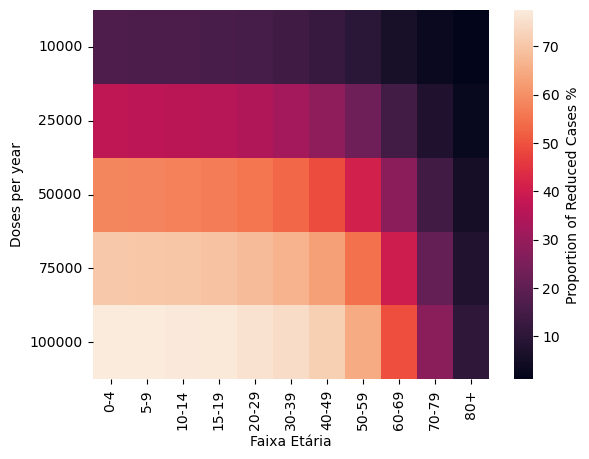

In [137]:
inf_str = np.array(inf_str)

ax = sns.heatmap(inf_str)

faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
ax.collections[0].colorbar.set_label("Proportion of Reduced Cases %")
ax.set(xticklabels = faixas_etarias, 
       yticklabels = np.round(np.array([0,10000,25000,50000,75000,100000])[1:],2),
      xlabel='Faixa Etária',
      ylabel="Doses per year") 
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.show()


### RJ Pattern

In [146]:
beta_aug = beta_2
inf_str = []
vacc_rates = (np.array([0,10000,25000,50000,75000,100000])/(365))*(1/pop)

for vacc_rate in vacc_rates:
    print(vacc_rate)
    inf_rates = []
    for i in range(N):
        inf_ano = []
        # before intervention
        #print('before intervention')
        r0_vec = np.zeros(11)
        y0 = define_initial_condition()
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N)))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,33:44] - ret[:-1,33:44]).sum(axis = 1).sum()
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()


        # after intervention
        #print('after intervention')
        r0_vec = np.zeros(11)
        r0_vec[i] = vacc_rate
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,33:44] - ret[:-1,33:44]).sum(axis = 1).sum()
            inf_ano.append(inf_total)
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()

        inf_rates.append(np.sum(inf_ano))
    inf_str.append(inf_rates)

0.0
2.3114616490985835e-06
5.778654122746459e-06
1.1557308245492919e-05
1.7335962368239375e-05
2.3114616490985837e-05


In [148]:
inf_str

[[5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016,
  5660907.420641016],
 [5305473.885769894,
  5349649.166952001,
  5387918.266888874,
  5422632.910248395,
  5479355.392201664,
  5533780.453468603,
  5578687.946571883,
  5612163.014216902,
  5632799.571426215,
  5648562.7742461,
  5655772.151312588],
 [4757547.118433169,
  4864721.6278154235,
  4962503.126109896,
  5049202.031794316,
  5196315.139132104,
  5338048.586267602,
  5451386.871466285,
  5535468.87941098,
  5594145.295093773,
  5628617.740956539,
  5650367.782918513],
 [3817169.886699025,
  4014806.1344712856,
  4201772.609070145,
  4376781.573171446,
  4680774.948045259,
  4984175.5483012665,
  5224697.7435600385,
  5402071.272928723,
  5521670.770601807,
  5596952.9603132885,
  5638999.095612987],
 [2869211.362734667,
  3121281.7802340984,
  3382751.2627168447,
  364

In [149]:
inf_str = np.array(inf_str)

In [150]:
inf_str = 100*abs(inf_str-5659425.555238572)/(5659425.555238572)

In [151]:
inf_str = inf_str[1:,:]

In [152]:
inf_str

array([[6.25419782e+00, 5.47363660e+00, 4.79743546e+00, 4.18404028e+00,
        3.18177457e+00, 2.22010345e+00, 1.42660431e+00, 8.35111984e-01,
        4.70471491e-01, 1.91941406e-01, 6.45543243e-02],
       [1.59358654e+01, 1.40421306e+01, 1.23143669e+01, 1.07824287e+01,
        8.18299334e+00, 5.67861466e+00, 3.67596820e+00, 2.19026957e+00,
        1.15347856e+00, 5.44362921e-01, 1.60047557e-01],
       [3.25519905e+01, 2.90598296e+01, 2.57561997e+01, 2.26638547e+01,
        1.72924018e+01, 1.19314231e+01, 7.68148300e+00, 4.54735697e+00,
        2.43407716e+00, 1.10386813e+00, 3.60928144e-01],
       [4.93020743e+01, 4.48480813e+01, 4.02280103e+01, 3.56697485e+01,
        2.73474719e+01, 1.88749832e+01, 1.20911889e+01, 7.14790703e+00,
        3.77951544e+00, 1.67939574e+00, 5.52239731e-01],
       [6.49651386e+01, 6.04032208e+01, 5.51733938e+01, 4.95511765e+01,
        3.86095796e+01, 2.65884831e+01, 1.69976795e+01, 1.00015126e+01,
        5.25225085e+00, 2.28870606e+00, 7.63793642e-

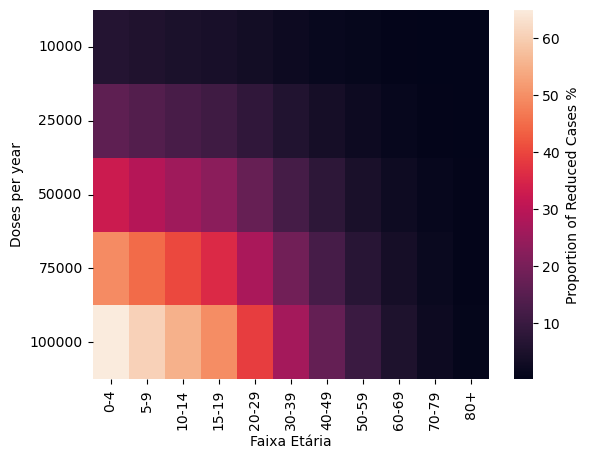

In [153]:
inf_str = np.array(inf_str)

ax = sns.heatmap(inf_str)

faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
ax.collections[0].colorbar.set_label("Proportion of Reduced Cases %")
ax.set(xticklabels = faixas_etarias, 
       yticklabels = np.round(np.array([0,10000,25000,50000,75000,100000])[1:],2),
      xlabel='Faixa Etária',
      ylabel="Doses per year") 
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.show()


## Part 3: including mortality rate - changing to the total number of deaths - time series

In [157]:
d_vec = np.array([0.0001, 0.0004, 0.0002, 0.0002, 0.0002, 0.0002, 0.0004, 0.0004,
       0.0017, 0.0017, 0.0097])

### SP Pattern

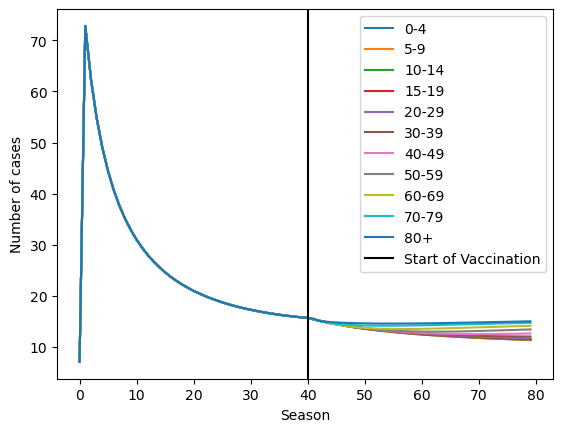

In [158]:
beta_aug = beta_1
inf_str = []

for i in range(N):
    inf_ano = []
    # before intervention
    #print('before intervention')
    r0_vec = np.zeros(N)
    y0 = define_initial_condition_2()
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine_death, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N), d_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,55:] - ret[:-1,55:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()


    # after intervention
    #print('after intervention')
    r0_vec = np.zeros(11)
    r0_vec[i] = ((10000)/365)*(1/pop)
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine_death, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec, d_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,55:] - ret[:-1,55:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()
    
    inf_str.append(inf_ano)
    
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.show()

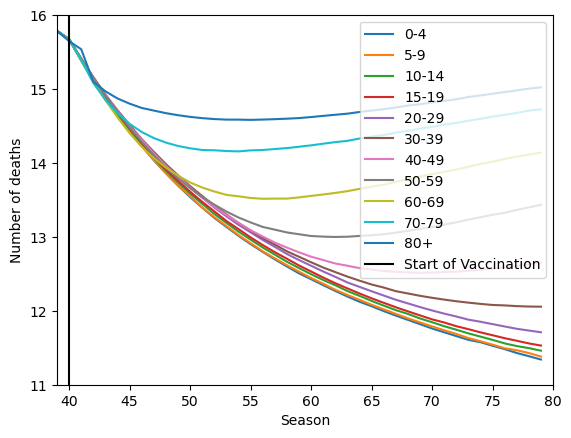

In [162]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylim((11,16))
plt.xlim((39,80))
plt.ylabel('Number of deaths')
plt.xlabel('Season')
plt.show()

### RJ Pattern

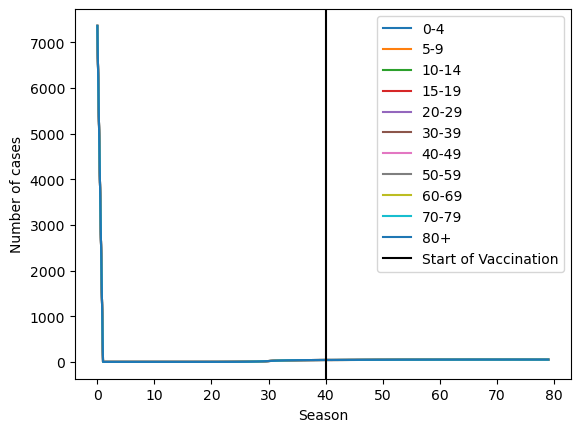

In [170]:
beta_aug = beta_2
inf_str = []

for i in range(N):
    inf_ano = []
    # before intervention
    #print('before intervention')
    r0_vec = np.zeros(N)
    y0 = define_initial_condition_2()
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine_death, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N), d_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,55:] - ret[:-1,55:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()


    # after intervention
    #print('after intervention')
    r0_vec = np.zeros(11)
    r0_vec[i] = ((10000)/365)*(1/pop)
    for season in np.arange(seasons):
        ret = odeint(n_groups_seasonal_model_vaccine_death, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec, d_vec))
        y0 = ret[-1,:].copy()
        y0 = modify_initial_condition(y0)
        inf_total = pop*(ret[1:,55:] - ret[:-1,55:]).sum(axis = 1).sum()
        inf_ano.append(inf_total)
        #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
        #plt.scatter((season*365)/365,y0[N:2*N].sum())
        #if(season == 0):
            #plt.show()
    #plt.legend()
    #plt.show()
    
    inf_str.append(inf_ano)
    
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylabel('Number of cases')
plt.xlabel('Season')
plt.show()

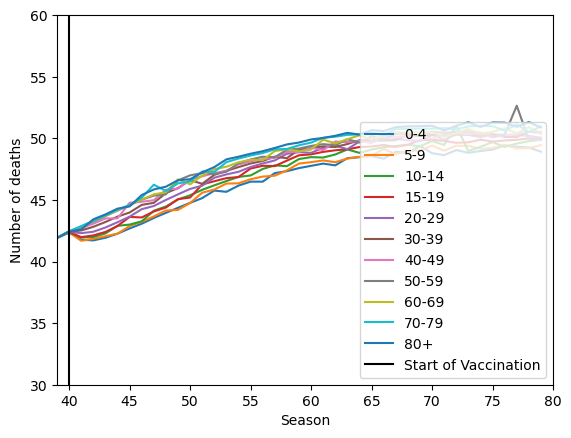

In [171]:
faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
for i in range(N):
    plt.plot(inf_str[i], label = str(faixas_etarias[i]))
plt.axvline(40,label = 'Start of Vaccination', color = 'k')
plt.legend()
plt.ylim((30,60))
plt.xlim((39,80))
plt.ylabel('Number of deaths')
plt.xlabel('Season')
plt.show()

## Part 4: including mortality rate - different vaccine rates and strategies

### SP Pattern

In [166]:
beta_aug = beta_1
inf_str = []
vacc_rates = (np.array([0,10000,25000,50000,75000,100000])/(365))*(1/pop)

for vacc_rate in vacc_rates:
    inf_rates = []
    for i in range(N):
        inf_ano = []
        # before intervention
        #print('before intervention')
        r0_vec = np.zeros(11)
        y0 = define_initial_condition_2()
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine_death, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, np.zeros(N), d_vec))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,55:] - ret[:-1,55:]).sum(axis = 1).sum()
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()


        # after intervention
        #print('after intervention')
        r0_vec = np.zeros(11)
        r0_vec[i] = vacc_rate
        for season in np.arange(seasons):
            ret = odeint(n_groups_seasonal_model_vaccine_death, y0, t_season_single, args=(N, pop, nu, beta_0,beta_aug,t_start,t_season,t_year, gamma, mu_vec, l_vec, r0_vec, d_vec))
            y0 = ret[-1,:].copy()
            y0 = modify_initial_condition(y0)
            inf_total = pop*(ret[1:,55:] - ret[:-1,55:]).sum(axis = 1).sum()
            inf_ano.append(inf_total)
            #plt.plot((t_season_single+season*365)/365,ret[:,N:2*N].sum(axis=1)*pop, label = season)
            #plt.scatter((season*365)/365,y0[N:2*N].sum())
            #if(season == 0):
                #plt.show()
        #plt.legend()
        #plt.show()

        inf_rates.append(np.sum(inf_ano))
    inf_str.append(inf_rates)

KeyboardInterrupt: 

In [ ]:
inf_str

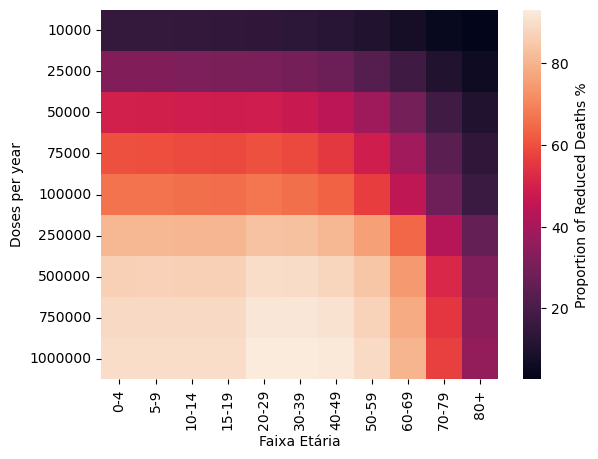

In [89]:
inf_str = np.array(inf_str)
inf_str = 100*abs(inf_str-608.8053227025346)/(608.8053227025346)
inf_str = inf_str[1:,:]
inf_str = np.array(inf_str)

ax = sns.heatmap(inf_str)

faixas_etarias = ['0-4','5-9','10-14','15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80+']
ax.collections[0].colorbar.set_label("Proportion of Reduced Deaths %")
ax.set(xticklabels = faixas_etarias, 
       yticklabels = np.round(np.array([0,10000,25000,50000,75000,100000,250000,500000,750000,1000000])[1:],2),
      xlabel='Faixa Etária',
      ylabel="Doses per year") 
plt.xticks(rotation = 'vertical')
plt.yticks(rotation = 'horizontal')
plt.show()